In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass


In [ ]:
@dataclass
class CFG:
    VIDEO_PATH: str = "data/easy/3_easy.mp4"
    WARP_SIZE: int = 900

    SHOW_DEBUG: bool = True
    SAVE_DEBUG: bool = False
    DEBUG_DIR: str = "debug_out"

    BOARD_SAMPLE_FRAMES: int = 80
    INNER_SAMPLE_FRAMES: int = 70

    BG_SAMPLES: int = 160
    BG_STRIDE: int = 3
    BG_MOG2_HISTORY: int = 400
    BG_MOG2_VAR: int = 18
    BG_ABSDIFF_THRESH: int = 22
    BG_OPEN_K: int = 3
    BG_CLOSE_K: int = 7
    BG_MIN_VISIBLE: int = 6

    MOTION_THRESH: int = 25
    MOTION_OPEN_K: int = 3
    MOTION_CLOSE_K: int = 7
    MOTION_ON_RATIO: float = 0.002
    MOTION_OFF_RATIO: float = 0.0008
    STABLE_FRAMES_N: int = 10

    PAWN_MIN_AREA: int = 200
    PAWN_MAX_AREA: int = 7000

    DICE_MIN_AREA: int = 500
    DICE_MAX_AREA: int = 25000

cfg = CFG()

if cfg.SAVE_DEBUG:
    os.makedirs(cfg.DEBUG_DIR, exist_ok=True)

print("VIDEO_PATH =", cfg.VIDEO_PATH)


VIDEO_PATH = data/easy/3_easy.mp4


In [3]:
def show(img, title="", figsize=(7,7)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

In [ ]:
def order_quad_pts(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    d = np.diff(pts, axis=1).reshape(-1)
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(d)]
    bl = pts[np.argmax(d)]
    return np.array([tl, tr, br, bl], dtype=np.float32)

def find_board_quad(frame_bgr):
    h, w = frame_bgr.shape[:2]
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(gray, 60, 160)
    edges = cv2.dilate(edges, np.ones((3, 3), np.uint8), iterations=1)

    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    for c in cnts[:12]:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4 and cv2.contourArea(approx) > 0.15 * (h * w):
            return order_quad_pts(approx.reshape(-1, 2))
    return None

def estimate_homography(video_path, warp_size=900, sample_frames=80):
    cap = cv2.VideoCapture(video_path)
    quads = []
    i = 0
    while i < sample_frames:
        ok, frame = cap.read()
        if not ok:
            break
        q = find_board_quad(frame)
        if q is not None:
            quads.append(q)
        i += 1
    cap.release()

    if len(quads) < 3:
        raise RuntimeError("Board quad not detected reliably. Try adjusting Canny thresholds or improve lighting.")

    quad_med = np.median(np.stack(quads, axis=0), axis=0).astype(np.float32)
    dst = np.array([[0,0],[warp_size-1,0],[warp_size-1,warp_size-1],[0,warp_size-1]], dtype=np.float32)
    H = cv2.getPerspectiveTransform(quad_med, dst)
    return H, quad_med

def warp_board(frame_bgr, H, warp_size=900):
    return cv2.warpPerspective(frame_bgr, H, (warp_size, warp_size))


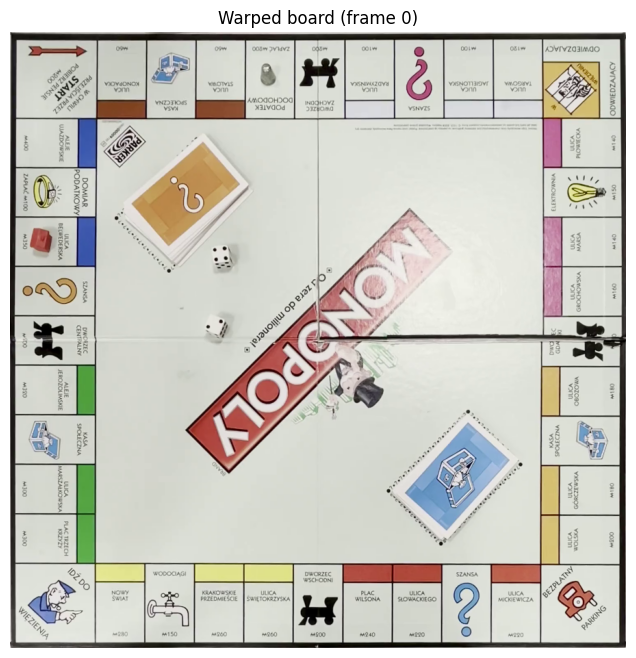

Homography ready.


In [ ]:
H, quad_med = estimate_homography(cfg.VIDEO_PATH, warp_size=cfg.WARP_SIZE, sample_frames=cfg.BOARD_SAMPLE_FRAMES)

cap = cv2.VideoCapture(cfg.VIDEO_PATH)
ok, frame0 = cap.read()
cap.release()
if not ok:
    raise RuntimeError("Cannot read video")

warped0 = warp_board(frame0, H, warp_size=cfg.WARP_SIZE)
show(warped0, "Warped board (frame 0)", figsize=(8,8))
print("Homography ready.")


In [ ]:
def inner_box_from_edge_profiles(warped_bgr, band_ratio=0.30, smooth_ksize=51, min_margin_ratio=0.06):
    s = warped_bgr.shape[0]
    gray = cv2.cvtColor(warped_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

    ax = np.abs(gx)
    ay = np.abs(gy)

    c = s // 2
    band = int(band_ratio * s)
    y1, y2 = max(0, c - band), min(s, c + band)
    x1, x2 = max(0, c - band), min(s, c + band)

    px = ax[y1:y2, :].mean(axis=0)
    py = ay[:, x1:x2].mean(axis=1)

    if smooth_ksize % 2 == 0:
        smooth_ksize += 1
    px = cv2.GaussianBlur(px.reshape(1, -1), (smooth_ksize, 1), 0).reshape(-1)
    py = cv2.GaussianBlur(py.reshape(-1, 1), (1, smooth_ksize), 0).reshape(-1)

    m = int(min_margin_ratio * s)
    left_range  = np.arange(m, c - m)
    right_range = np.arange(c + m, s - m)
    top_range   = np.arange(m, c - m)
    bot_range   = np.arange(c + m, s - m)

    if len(left_range) == 0 or len(right_range) == 0 or len(top_range) == 0 or len(bot_range) == 0:
        return None

    xl = int(left_range[np.argmax(px[left_range])])
    xr = int(right_range[np.argmax(px[right_range])])
    yt = int(top_range[np.argmax(py[top_range])])
    yb = int(bot_range[np.argmax(py[bot_range])])

    if xr - xl < 0.35 * s or yb - yt < 0.35 * s:
        return None

    return (xl, yt, xr, yb)

def estimate_inner_box_median(video_path, H, warp_size=900, n_frames=70,
                              band_ratio=0.30, smooth_ksize=51, min_margin_ratio=0.06):
    cap = cv2.VideoCapture(video_path)
    boxes = []
    tries = 0
    while len(boxes) < n_frames:
        ok, frame = cap.read()
        if not ok:
            break
        warped = warp_board(frame, H, warp_size=warp_size)
        box = inner_box_from_edge_profiles(
            warped,
            band_ratio=band_ratio,
            smooth_ksize=smooth_ksize,
            min_margin_ratio=min_margin_ratio
        )
        if box is not None:
            boxes.append(box)
        tries += 1
        if tries > n_frames * 5:
            break
    cap.release()

    if len(boxes) < max(10, n_frames // 4):
        raise RuntimeError("Too few inner boxes. Try band_ratio=0.33 and smooth_ksize=61.")

    b = np.array(boxes, dtype=np.float32)
    med = np.median(b, axis=0)
    return tuple(int(round(x)) for x in med)

def draw_box(img, box, color=(0,0,255), thickness=3):
    x1, y1, x2, y2 = box
    out = img.copy()
    cv2.rectangle(out, (x1,y1), (x2,y2), color, thickness)
    return out


In [ ]:
inner_box = estimate_inner_box_median(
    cfg.VIDEO_PATH, H, warp_size=cfg.WARP_SIZE,
    n_frames=cfg.INNER_SAMPLE_FRAMES, band_ratio=0.30, smooth_ksize=51, min_margin_ratio=0.06
)

vis_inner = draw_box(warped0, inner_box, color=(0,0,255), thickness=3)
# show(vis_inner, "Warped board + inner square", figsize=(8,8))
print("inner_box =", inner_box)


inner_box = (124, 126, 777, 777)


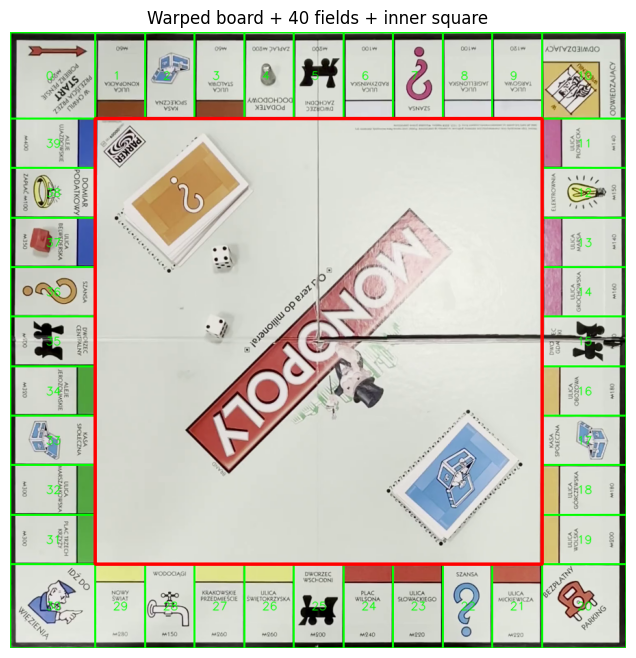

{'t_left': 124, 't_top': 126, 't_right': 123, 't_bottom': 123, 'cell_x': 72.55555555555556, 'cell_y': 72.33333333333333}


In [8]:
# %%
def build_monopoly_fields_robust(warp_size, inner_box):
    s = warp_size
    x1, y1, x2, y2 = inner_box

    t_left   = int(max(1, x1))
    t_top    = int(max(1, y1))
    t_right  = int(max(1, s - x2))
    t_bottom = int(max(1, s - y2))

    cell_x = (s - t_left - t_right) / 9.0
    cell_y = (s - t_top - t_bottom) / 9.0

    def rect(ax1, ay1, ax2, ay2):
        return (int(round(ax1)), int(round(ay1)), int(round(ax2)), int(round(ay2)))

    fields = []

    fields.append(rect(0, 0, t_left, t_top))
    for i in range(1, 10):
        xa1 = t_left + (i - 1) * cell_x
        xa2 = t_left + i * cell_x
        fields.append(rect(xa1, 0, xa2, t_top))

    fields.append(rect(s - t_right, 0, s, t_top))
    for i in range(1, 10):
        ya1 = t_top + (i - 1) * cell_y
        ya2 = t_top + i * cell_y
        fields.append(rect(s - t_right, ya1, s, ya2))

    fields.append(rect(s - t_right, s - t_bottom, s, s))
    for i in range(1, 10):
        xb2 = (s - t_right) - (i - 1) * cell_x
        xb1 = (s - t_right) - i * cell_x
        fields.append(rect(xb1, s - t_bottom, xb2, s))

    fields.append(rect(0, s - t_bottom, t_left, s))
    for i in range(1, 10):
        yl2 = (s - t_bottom) - (i - 1) * cell_y
        yl1 = (s - t_bottom) - i * cell_y
        fields.append(rect(0, yl1, t_left, yl2))

    return fields, {
        "t_left": t_left, "t_top": t_top, "t_right": t_right, "t_bottom": t_bottom,
        "cell_x": cell_x, "cell_y": cell_y
    }

def draw_fields(warped_bgr, fields, thickness=2, put_ids=True):
    out = warped_bgr.copy()
    for i, (x1,y1,x2,y2) in enumerate(fields):
        cv2.rectangle(out, (x1,y1), (x2,y2), (0,255,0), thickness)
        if put_ids:
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            cv2.putText(out, str(i), (cx-10, cy+6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,255,0), 1, cv2.LINE_AA)
    return out



fields, meta = build_monopoly_fields_robust(cfg.WARP_SIZE, inner_box)
vis_fields = draw_fields(warped0, fields, thickness=2, put_ids=True)
vis_fields = draw_box(vis_fields, inner_box, color=(0,0,255), thickness=3)
show(vis_fields, "Warped board + 40 fields + inner square", figsize=(8,8))
print(meta)


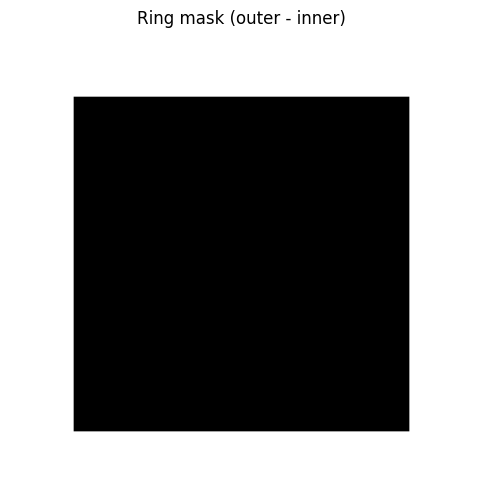

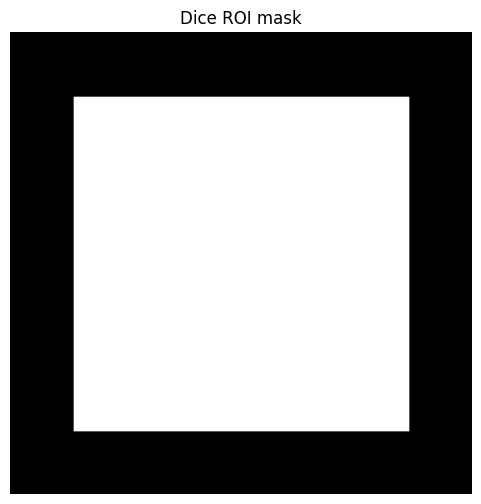

In [ ]:
def rect_mask(shape_hw, rect):
    h, w = shape_hw
    x1, y1, x2, y2 = rect
    m = np.zeros((h, w), dtype=np.uint8)
    cv2.rectangle(m, (x1, y1), (x2, y2), 255, thickness=-1)
    return m


S = cfg.WARP_SIZE
xl, yt, xr, yb = inner_box

outer_mask = rect_mask((S, S), (0, 0, S, S))
inner_mask = rect_mask((S, S), (xl, yt, xr, yb))
ring_mask = cv2.subtract(outer_mask, inner_mask)


dice_roi = (int(xl), int(yt), int(xr), int(yb))
dice_roi_mask = inner_mask

if cfg.SHOW_DEBUG:
    show(ring_mask, "Ring mask (outer - inner)", figsize=(6,6))
    show(dice_roi_mask, "Dice ROI mask", figsize=(6,6))



In [ ]:
import json

def _field_centers(fields):
    centers = []
    for (x1, y1, x2, y2) in fields:
        centers.append(((x1 + x2) / 2.0, (y1 + y2) / 2.0))
    return centers

def save_fields_coords(path, H, warp_size, inner_box, fields, dice_roi):
    payload = {
        "warp_size": int(warp_size),
        "H": np.asarray(H, dtype=float).tolist(),
        "inner_box": [int(v) for v in inner_box],
        "dice_roi": [int(v) for v in dice_roi],
        "fields": []
    }
    centers = _field_centers(fields)
    for i, (rect, (cx, cy)) in enumerate(zip(fields, centers)):
        x1, y1, x2, y2 = rect
        payload["fields"].append({
            "id": int(i),
            "rect": [int(x1), int(y1), int(x2), int(y2)],
            "center": [float(cx), float(cy)]
        })

    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)

def rect_intersection_area(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    if ix2 <= ix1 or iy2 <= iy1:
        return 0
    return (ix2 - ix1) * (iy2 - iy1)


FIELDS_JSON = "fields_coords.json"
save_fields_coords(FIELDS_JSON, H, cfg.WARP_SIZE, inner_box, fields, dice_roi)
print("Saved field coordinates to:", FIELDS_JSON)


Saved field coordinates to: fields_coords.json


In [11]:
# %%
def compute_clean_background_v2(
    video_path, H, warp_size,
    n_samples=240, stride=2,
    mog2_history=500, mog2_varThreshold=14,
    open_k=3, close_k=9,
    min_visible_count=6,
    keep_best_frac=0.25,          # keep best 25% frames (least FG)
    roi_mask=None,
    return_debug=False
):
    cap = cv2.VideoCapture(video_path)
    mog = cv2.createBackgroundSubtractorMOG2(
        history=mog2_history,
        varThreshold=mog2_varThreshold,
        detectShadows=False
    )

    frames = []
    fgs = []
    ratios = []

    i = 0
    while len(frames) < n_samples:
        ok, frame = cap.read()
        if not ok:
            break
        if i % stride == 0:
            warped = warp_board(frame, H, warp_size=warp_size)
            fg = mog.apply(warped)

            fg = (fg > 0).astype(np.uint8) * 255
            if open_k > 1:
                k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_k, open_k))
                fg = cv2.morphologyEx(fg, cv2.MORPH_OPEN, k, iterations=1)
            if close_k > 1:
                k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_k, close_k))
                fg = cv2.morphologyEx(fg, cv2.MORPH_CLOSE, k, iterations=1)

            if roi_mask is not None:
                fg_roi = cv2.bitwise_and(fg, fg, mask=roi_mask)
                r = float(np.count_nonzero(fg_roi)) / float(np.count_nonzero(roi_mask))
            else:
                r = float(np.count_nonzero(fg)) / float(fg.size)

            frames.append(warped)
            fgs.append(fg)
            ratios.append(r)
        i += 1

    cap.release()
    if len(frames) < 20:
        raise RuntimeError("Too few frames for background building v2.")

    frames = np.stack(frames, axis=0).astype(np.uint8)   # (T,H,W,3)
    fgs = np.stack(fgs, axis=0).astype(np.uint8)         # (T,H,W)
    ratios = np.array(ratios, dtype=float)

    # keep only the cleanest frames (lowest FG ratio)
    k = max(10, int(len(ratios) * keep_best_frac))
    keep_idx = np.argsort(ratios)[:k]

    frames_k = frames[keep_idx]
    fgs_k = fgs[keep_idx]

    mask_bg = (fgs_k == 0)
    visible_count = mask_bg.sum(axis=0)

    bg = np.zeros_like(frames_k[0], dtype=np.uint8)
    for c in range(3):
        vals = frames_k[..., c].astype(np.float32)
        vals[~mask_bg] = np.nan
        med = np.nanmedian(vals, axis=0)
        bg[..., c] = np.nan_to_num(med, nan=0).astype(np.uint8)

    holes = (visible_count < min_visible_count).astype(np.uint8) * 255
    if np.count_nonzero(holes) > 0:
        bg = cv2.inpaint(bg, holes, 3, cv2.INPAINT_TELEA)

    if return_debug:
        return bg, ratios, keep_idx, holes
    return bg


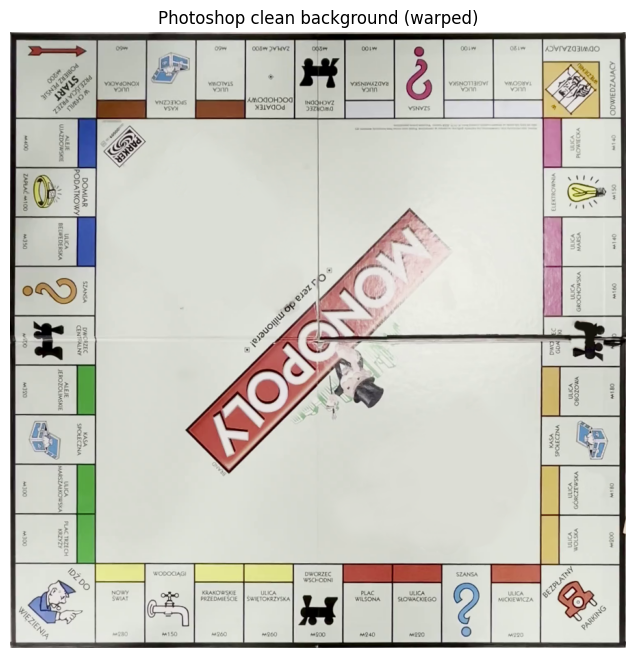

In [ ]:
USE_PHOTOSHOP_BG = True
PHOTOSHOP_BG_PATH = "warped_board_clean.png" 

if USE_PHOTOSHOP_BG:
    bg_clean = cv2.imread(PHOTOSHOP_BG_PATH)
    if bg_clean is None:
        raise RuntimeError(f"Cannot read {PHOTOSHOP_BG_PATH}. Check path.")
    if bg_clean.shape[0] != cfg.WARP_SIZE or bg_clean.shape[1] != cfg.WARP_SIZE:
        bg_clean = cv2.resize(bg_clean, (cfg.WARP_SIZE, cfg.WARP_SIZE), interpolation=cv2.INTER_AREA)

    show(bg_clean, "Photoshop clean background (warped)", figsize=(8, 8))
else:
    bg_clean = compute_clean_background_v2(
        cfg.VIDEO_PATH, H, cfg.WARP_SIZE,
        n_samples=240,
        stride=2,
        mog2_history=500,
        mog2_varThreshold=14,
        open_k=3,
        close_k=9,
        min_visible_count=6,
        keep_best_frac=0.25,
        roi_mask=ring_mask,
        return_debug=False
    )
    show(bg_clean, "Clean background v2 (warped)", figsize=(8, 8))



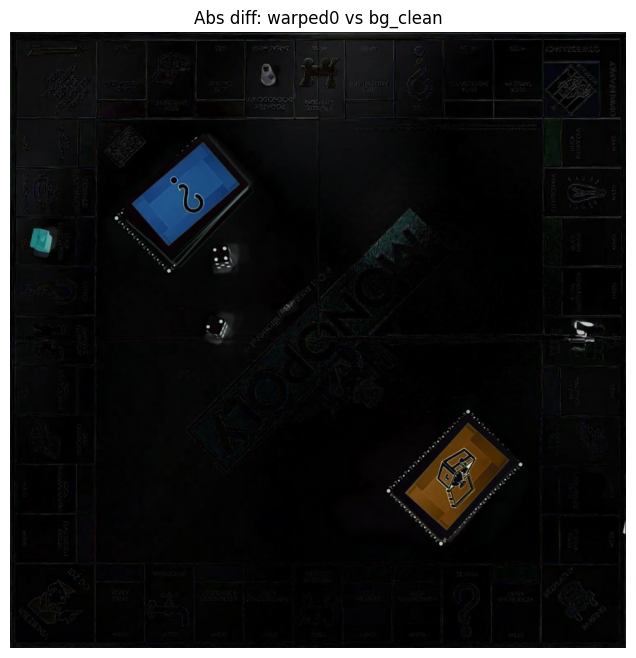

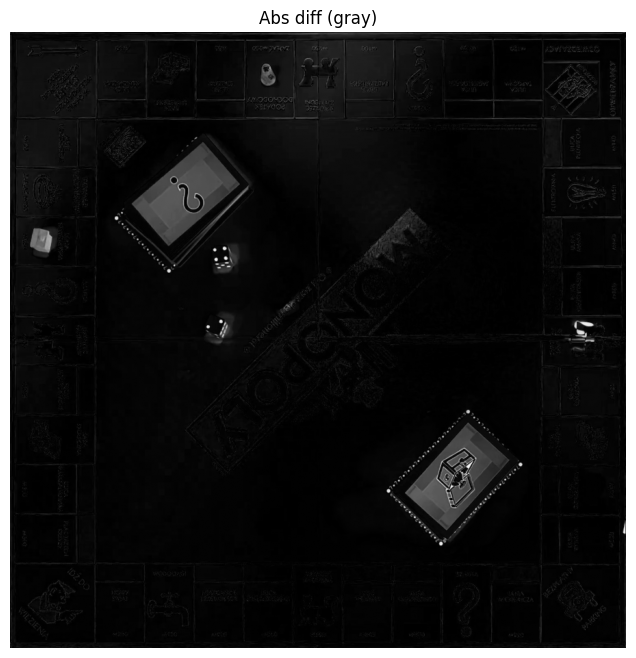

Mean diff gray: 8.334361728395061  | 95% percentile: 29.0


In [ ]:
diff0 = cv2.absdiff(warped0, bg_clean)
show(diff0, "Abs diff: warped0 vs bg_clean", figsize=(8,8))

diff0g = cv2.cvtColor(diff0, cv2.COLOR_BGR2GRAY)
show(diff0g, "Abs diff (gray)", figsize=(8,8))
print("Mean diff gray:", float(diff0g.mean()), " | 95% percentile:", float(np.percentile(diff0g, 95)))
